# Study of $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ candidates in Pythia8 proton-proton collisions
This is a brief introduction to the application of Machine Learning (ML) techniques in High Energy Physics. In notebook, you will try to train a ML algorithm to distinguish $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ from a general sample of proton-proton collisions at an energy of $450~\text{GeV}$ (similar to the SPS energy). In other words, we will try to construct the algorithm in such a way that has a high efficiency on $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ candidates and a high rejection in any other kind of signals. This is a classification problem. Let's start by loading the necessary scikit-learn classes and functions that will allow us to train the ML algorithm and study its performance.

In [1]:
%matplotlib inline
%run auxiliar/shared.ipynb
import hep_lessons_ml
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib import animation, rc

rc('animation', html='html5') # if html='none' the animation is not displayed

np.random.seed(4857) # so everybody gets the same results

pandas.set_option('display.max_columns', 500) # so all the columns of DataFrame instances are printed

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier

## Training the algorithm
We will start by loading a sample to work with. In this case we will use a sample of proton-proton collisions where candidates have been built from two particles with opposite charge and with loose requirements on the transverse momentum and impact parameter with respect to the proton-proton collision point. This has been done in order to decrease the background level with a reduced impact on the efficiency. It becomes necessary to identify what we consider as *signal* and as *background* in order to train the algorithm. In many cases, the choice of a correct *signal* or *background* proxy depends on the specific problem we want to solve. In our case we can use the information from the simulated sample in order to get a pure sample of simulated $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ and background candidates.

In [2]:
sample = sample_to_dataframe('reco_pp_450.0_400000.hdf5', key='root', stop=None)

pid_cond = (sample['p1_pid'] == +211) & (sample['p2_pid'] == -211)  # two pions with opposite sign

head_cond = (sample['p1_head_rid'] == sample['p2_head_rid']) & (sample['p1_head_pid'] == 310)  # common head (a KS0)

sample.loc[:,'signal'] = pid_cond & head_cond

# This is the list of variables you can are suggested to include/exclude from the classifier
variable_candidates = [
    # Kinematical
    'head_p', # momentum
    'head_pt', # transverse momentum
    'head_ctau', # lifetime (multiplied by the speed of light)
    'head_fd', # flight distance
    'p1_p',
    'p1_pt',
    'p2_p',
    'p2_pt',
    # Impact parameters
    'head_ip',
    'p1_ip',
    'p2_ip',
    # Vertex-related
    'pv_x', # primary vertex position (proton-proton collision point)
    'pv_y',
    'pv_z',
    'head_sv_x', # decay vertex position (where the KS0 decays)
    'head_sv_y',
    'head_sv_z',
    'head_doca',
]

print(sample[variable_candidates].describe(include='all'))

              head_p        head_pt     head_ctau       head_fd  \
count  273736.000000  273736.000000  2.737360e+05  2.737360e+05   
mean       10.778664       0.515847  1.111364e+02  1.131033e+03   
std        20.682754       0.354753  9.781257e+03  5.518030e+04   
min         0.015783       0.000233  2.088065e-02  1.096502e-01   
25%         1.186193       0.271521  1.006305e+01  4.133555e+01   
50%         3.156445       0.439053  2.247646e+01  1.395659e+02   
75%         9.946304       0.669860  4.523406e+01  5.185262e+02   
max       224.623938       9.002537  4.721800e+06  2.344944e+07   

                p1_p          p1_pt           p2_p          p2_pt  \
count  273736.000000  273736.000000  273736.000000  273736.000000   
mean        6.834611       0.318760       4.059096       0.297807   
std        16.560163       0.249260       7.260511       0.238787   
min         0.050049       0.048908       0.050001       0.049040   
25%         0.504241       0.147597       0.498051 

The Particle ID (PID) is a number that defines the particle in simulation (set by convention). The value *rid* is an integer that identifies the particle within the same event. By asking the decay products to have *PID* equal to +211 for *p1* and -211 for *p2* we are getting combinations of a $\pi^+$ and a $\pi^-$, and the *PID* of the head equal to 310 corresponds to a $K_\rm{S}^0$. Finally, we ask the two decay products to have a head particle with the same *rid*, so they are products of the same decay. Note that it is not ensured that there are no more particles involved in the decay (and so the signal candidates might not correspond exclusively to $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ decays. However, if you look in the PDG, there are no other decays of the type $K_\rm{S}^0\rightarrow \pi^+\pi^- X$ with a high branching fraction, so most of our candidates will correspond to our signal decay.

Now we must split the sample in two. The first part will be used to train the algorithm and the second to test it. This must be done in order to do checks for overtraining and get correct estimates for the performance of the algorithm. We will split the sample in such a way that $2/3$ of the data sample is used to train the algorithm and the reminaining $1/3$ is used to test it.

In [3]:
sample.loc[:,'train'] = train_mask(sample, train_test_ratio=2.)

Now we have to build the classifier. We have to choose two things: a classifier and a set of characteristic variables.

The choice of the classifier can be crucial in order to solve a particular problem. For classification problems of this kind, the use of adaptive boosted decision trees has always shown a very good performance, similar to neural networks. In many cases, the differences between the two are marginal, and  the performance is more limited by other sources (statistics, simulation performance, ...) than by the algorithm itself.

For the variables, we must choose those that present differences between signal and background proxies, in such a way that the classifier can exploit those differences in order to build a discriminant to separate both components. It is convenient to do a preliminar study of the signal and background samples in order to determine the variables to use. You can find more details in [this notebook](auxiliar/preliminar.ipynb). Note that the ML algorithms do not only use the information from the variables themselves, but also from the correlations among them. A classifier can be able to separate components with similar distribution for all the variables, where rectangular cuts like $p_T > 100~\text{MeV}/c$ become useless, as long as the correlation among the variables is different for signal and background proxies. In this case we will use the distance of closest approach between the two decay product tracks, the impact parameters of all the particles, their transverse momenta.

In this case we will build and adaptive boosted decision tree.

In [4]:
classifier = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
        max_depth=5, min_samples_leaf=0.1, max_features='auto'), learning_rate=0.2, n_estimators=50)

variables = ['head_doca', 'head_ip', 'p1_ip', 'p2_ip', 'head_pt', 'p1_pt', 'p2_pt']

classifier.fit(sample[sample['train']][variables], sample[sample['train']]['signal']); # remember to use the "train" sample

Now *classifier* has been fitted and we can use it in order to predict the probability for a general candidate to be a $K_\rm{S}^0 \rightarrow \pi^+\pi^-$. Let's predict this probability in both the train and test samples.

In [5]:
sample.loc[:,'bkg_proba'], sample.loc[:,'sig_proba'] = classifier.predict_proba(sample[variables]).T

Note that the call to *predict_proba* returns two values, of the background and signal probabilities. We could train the same algorithm to distinguish among more than two different components, so each element of the output would represent the probability of the candidate to belong to each group.

You can check that the algorithm behaves as expected applying a requirement on it, and check its behaviour for different requirements on the signal probability.

In [6]:
%%capture
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12 ,4))

hist_kwargs = dict(range=(0.4, 0.6), bins=100)

common = dict(histtype='step', density=True, **hist_kwargs)

sample_test = sample[~sample['train']]

# Plot the invariant mass with and without a requirement on the signal probability
_, edges, _ = ax0.hist(sample_test['head_m'], linestyle='--', label='no requirement', **common)
ax0.hist(sample_test[sample_test['sig_proba'] > 0.6]['head_m'], linestyle='-', label='requirement applied', **common)
ax0.set_xlabel('head_m')
ax0.legend();

In [7]:
%%capture

# Fancy animation showing how the background level decreases with the requirement
sig, bkg = split_sig_bkg(sample_test)

x = np.repeat(edges, 2)
y_bkg = np.zeros(2 * len(edges), dtype=np.float)
y_sig = np.zeros(2 * len(edges), dtype=np.float)

ax1.set_xlim(*ax0.get_xlim())
ax1.set_ylim(0, 4) # must use constant limits
ax1.set_xlabel('head_m (different scales)')

t = 'sig_proba > {value:.4f}'

line_bkg, line_sig, = ax1.plot([], [], '--', [], '-')
text = ax1.text(0.05, 0.90, t.format(value=0), transform=ax1.transAxes)

ax1.legend([line_bkg, line_sig], ['bkg', 'sig'])

def init():
    line_bkg.set_data([], [])
    line_sig.set_data([], [])
    text.set_text(t.format(value=0))
    return line_bkg, line_sig, text

def animate(v):

    # Histograms are rescaled to see the effect of the requirements more clear
    bkg_smp = bkg[bkg['sig_proba'] > v]
    y_bkg[+1:-1] = np.repeat(np.histogram(bkg_smp['head_m'], **hist_kwargs)[0], 2) * 100 / len(bkg)
    
    line_bkg.set_data(x, y_bkg)        

    sig_smp = sig[sig['sig_proba'] > v]
    y_sig[+1:-1] = np.repeat(np.histogram(sig_smp['head_m'], **hist_kwargs)[0], 2) * 10 / len(sig)
    
    line_sig.set_data(x, y_sig)
    
    text.set_text(t.format(value=v))
    
    return line_bkg, line_sig, text

pmin, pmax = sample_test['sig_proba'].min(), sample_test['sig_proba'].max()

theta = np.linspace(0, np.pi, 101, dtype=np.float)
frames = pmin + (pmax - pmin) * np.sin(theta)

In [8]:
animation.FuncAnimation(fig, animate, init_func=init, frames=frames, blit=True)

Now that we have evaluated the algorithm and we checked that it works, we are ready to start studying its performance.

## Evaluating the performance of the algorithm
In general there are two checks that done right after training a ML algorithm. These are an overtraining check, and the study of the ROC curve.

### Overtraining
In order to understand overtraining, it becomes adecutate to think about the differences between a *sample* and a *population*. Experimentally we measure properties of a *sample* that belongs to a *population*. In this case, the *population* is composed by $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ decays in proton-proton collisions. Taking random candidates from proton-proton collisions we get a *sample* that is an unbiased proxy of the *population*, so we can infer the properties of any $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ candidate by studying our generated sample. Each candidate in the *sample* has certain values for the variables we use to train a ML algorithm. An algorithm is said to be overtrained when it has focused on particular features of a *sample*, rather on the general properties of the *population*. This way, the algorithm will be able to select efficiently candidates from the signal proxy that was used for training, but will be unoptimal to select other candidates belonging to the same population ($K_\rm{S}^0 \rightarrow \pi^+\pi^-$ from other simulated sample). This can turn VERY dangerous when estimating efficiencies, for example, and must be avoided if not treated properly. One way to check the overtraining is by looking at the distribution of the classifier in the training and test samples (for both signal and background proxies), which must coincide.

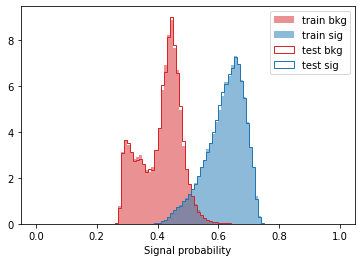

In [9]:
sample_train, sample_test = sample[sample['train']], sample[~sample['train']]

plot_overtraining('sig_proba', sample_train, sample_test)

### ROC curves
It is quite common to use the Receiver Operating Characteristic (ROC) curve and in particular its area, as a figure of merit to rank ML algorithms. A greater area means that the algorithm is able to rejectmore background whilst keeping a higher efficiency. It can be easily calculated as

Area under curve: 0.9863382554744052


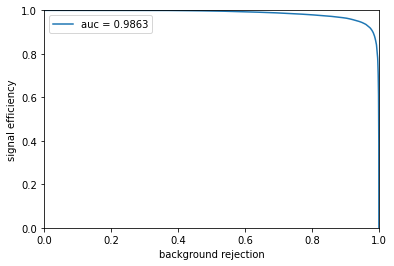

In [10]:
rauc = plot_roc('sig_proba', sample_test)

print(f'Area under curve: {rauc}')

### Correlation with variables of interest
It becomes very important to check the correlation of our ML classifier with variables of interest that will be used in our analysis. If we want to study the invariant mass of the $K_\rm{S}^0 \rightarrow \pi^+\pi^-$ candidates, by fitting our sample, it is necessary to check that a requirement on the signal probability does not distort the invariant mass shapes (of both signal and background) in such a way that we can not parameterize them correctly. An extreme case can be if we allow our classifier to acccess the invariant mass of the $K_\rm{S}^0$. If so, it can use the information of this variable in order to distinguish $K_\rm{S}^0$ over the background and distort the dipion invariant mass in such a way that the background proxy reveals a peak around the $K_\rm{S}^0$ nominal mass. This will make things really difficult in a posterior fit to the invariant mass shape.

The previously trained classifier is only slightly correlated with the mass (acceptable for a posterior analysis), as you can check in the following plots.

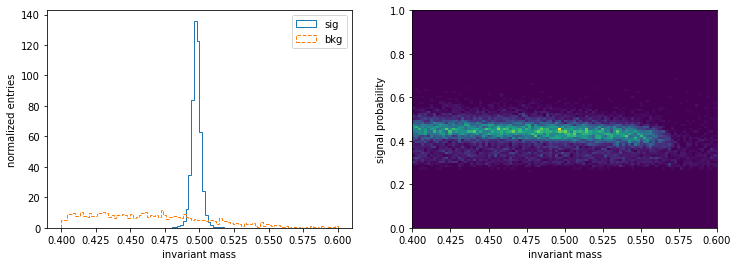

In [11]:
test_sig, test_bkg = split_sig_bkg(sample_test)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(12, 4))

common = dict(range=(0.4, 0.6), bins=100, density=True, histtype='step')

ax0.hist(test_sig[test_sig['sig_proba'] > 0.5]['head_m'], linestyle='-', label='sig', **common)
ax0.hist(test_bkg[test_bkg['sig_proba'] > 0.5]['head_m'], linestyle='--', label='bkg', **common)
ax0.set_xlabel('invariant mass');
ax0.set_ylabel('normalized entries');
ax0.legend();
ax1.hist2d(test_bkg['head_m'], test_bkg['sig_proba'], bins=(100, 100), range=((0.4, 0.6), (0, 1)), density=True)
ax1.set_xlabel('invariant mass');
ax1.set_ylabel('signal probability');

However, let's train the algorithm including the invariant mass in the set of variables passed to the classifier. 

In [12]:
# Train again the classifier with the new variables
classifier_bias = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(
        max_depth=5, min_samples_leaf=0.1, max_features='auto'), learning_rate=0.2, n_estimators=50)

variables_bias = variables + ['head_m']

classifier_bias.fit(sample[sample['train']][variables_bias], sample[sample['train']]['signal']);

# Add a column to the DataFrame with the "biased" classifier
sample.loc[:,'bkg_proba_bias'], sample.loc[:,'sig_proba_bias'] = classifier_bias.predict_proba(
                                                                sample[variables_bias]).T

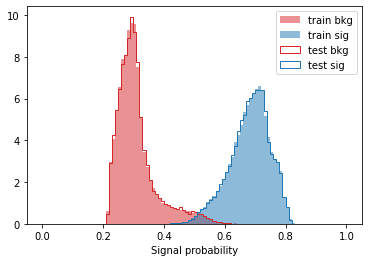

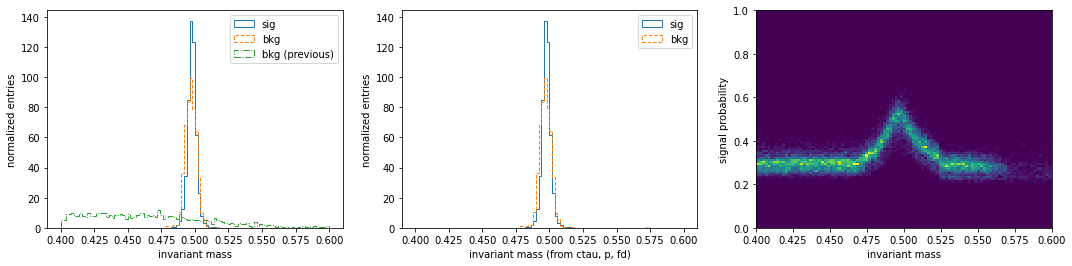

In [13]:
# Repeat the plotting process
sample_train_bias, sample_test_bias = sample[sample['train']], sample[~sample['train']]

plot_overtraining('sig_proba_bias', sample_train_bias, sample_test_bias)

test_sig, test_bkg = split_sig_bkg(sample_test_bias)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(18, 4))

common = dict(range=(0.4, 0.6), bins=100, density=True, histtype='step')

test_bkg_sc = test_bkg[test_bkg['sig_proba_bias'] > 0.5]
test_sig_sc = test_sig[test_sig['sig_proba_bias'] > 0.5]

ax0.hist(test_sig_sc['head_m'], linestyle='-', label='sig', **common)
ax0.hist(test_bkg_sc['head_m'], linestyle='--', label='bkg', **common)
ax0.hist(test_bkg[test_bkg['sig_proba'] > 0.5]['head_m'], linestyle='-.', label='bkg (previous)', **common)
ax0.set_xlabel('invariant mass');
ax0.set_ylabel('normalized entries');
ax0.legend();
ax1.hist(test_sig_sc['head_ctau'] * test_sig_sc['head_p'] / test_sig_sc['head_fd'], label='sig', **common)
ax1.hist(test_bkg_sc['head_ctau'] * test_bkg_sc['head_p'] / test_bkg_sc['head_fd'], linestyle='--', label='bkg', **common)
ax1.set_xlabel('invariant mass (from ctau, p, fd)');
ax1.set_ylabel('normalized entries');
ax1.legend();
ax2.hist2d(test_bkg['head_m'], test_bkg['sig_proba_bias'], bins=(100, 100),
                                   range=((0.4, 0.6), (0, 1)), density=True)
ax2.set_xlabel('invariant mass');
ax2.set_ylabel('signal probability');

As you can see, the invariant mass of the background has changed an is close to that of the signal. Even if we do not include the invariant mass directly, an ML algorithm might be able to "construct" it from the training variables. For example, if we provide the classifier with the decay time, the flight distance multiplied by the speed of light and the momentum of the head particle, the invariant mass can be calculated as $m = \frac{\tau p}{d}$. If you provide the algorithm with such information you will more likely not see any bias in the invariant mass shape. This is due to the fact that in this example the background is very different to the signal, and the ML algorithm is able to separate efficiently the background without needing to infer properties os the sample with that level of complexity (you can get a similar performance using rectangular cuts). However, when working with real data and very rare signals, quite often you will manage to remove most of the background applying rectangular cuts (with no losses) and use a ML algorithm in order to fight the background that is more similar to your signal, a case where infering complex quantities from a sample might be the only way to efficiently separate the two components.

## What next?
You can play around with the previous lines in order to see the effects of the different variables in the ML classifier, or you try to design the algorithm to select a different kind of signal. For example, could you redesign the notebook in such a way that the classifier selects $\Lambda^0 \rightarrow p\pi^-$ decays? You can consult the PID of the particles at

http://pdg.lbl.gov/2019/reviews/rpp2019-rev-monte-carlo-numbering.pdf

in order to get the *signal* and *background* proxies. Take into account that, whilst the $K_\rm{S}^0$ mode is CP invariant (interchanging particles and antiparticles leads to the same result) for the $\Lambda^0$ it is not. You will need to redefine the values of the masses and the energies (but not the momenta, since it is the quantity that we measure in the laboratory) of the particles in order to get the correct invariant mass. It is recommended that you define a new DataFrame where *p1* is the heaviest decay product (proton or antiproton) and *p2* the pion. You can do it as follows:

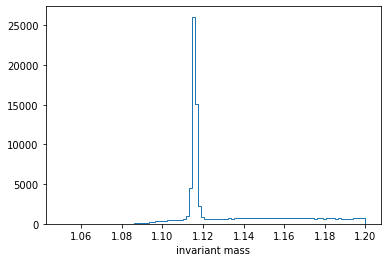

In [14]:
lambda_sample = sample.copy() # so we work with a different sample

# redefine the signal candidates
rid_cond = (lambda_sample['p1_head_rid'] == lambda_sample['p2_head_rid'])

baryon_dp_cond = (lambda_sample['p1_pid'] == +2212) & (lambda_sample['p2_pid'] == -211) # proton + pion(-)
antibaryon_dp_cond = (lambda_sample['p1_pid'] == +211) & (lambda_sample['p2_pid'] == -2212) # anti-proton + pion(+)

baryon_cond     = lambda_sample['p1_head_pid'] == +3122 # Lambda0
antibaryon_cond = lambda_sample['p1_head_pid'] == -3122 # anti-Lambda0

head_baryon_cond     = rid_cond & baryon_dp_cond & baryon_cond
head_antibaryon_cond = rid_cond & antibaryon_dp_cond & antibaryon_cond

lambda_sample.loc[:,'baryon'] = head_baryon_cond # baryon category
lambda_sample.loc[:,'antibaryon'] = head_antibaryon_cond # antibaryon category

lambda_sample.loc[:,'signal'] = head_baryon_cond | head_antibaryon_cond # signal category

# swap the particles for the antibaryon sample
for c in filter(lambda c: c.startswith('p1'), lambda_sample.columns):
    p = c.replace('p1', 'p2', 1)
    tmp = lambda_sample.loc[lambda_sample['antibaryon'], p].copy()
    lambda_sample.loc[lambda_sample['antibaryon'], p] = lambda_sample.loc[lambda_sample['antibaryon'], p]
    lambda_sample.loc[lambda_sample['antibaryon'], c] = tmp
    
# recalculate the energy and invariant mass of the particles
proton_mass = 0.93827208816
pion_mass = 0.13957018

for p, m in ('p1', proton_mass), ('p2', pion_mass):
    lambda_sample[f'{p}_m'] = m
    lambda_sample[f'{p}_e'] = np.sqrt(lambda_sample[f'{p}_p']**2 + m**2)
    
lambda_sample[f'head_e'] = lambda_sample['p1_e'] + lambda_sample['p2_e']
lambda_sample[f'head_m'] = np.sqrt(lambda_sample['head_e']**2 - lambda_sample['head_p']**2)

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

ax.hist(lambda_sample['head_m'], range=(1.05, 1.2), bins=100, histtype='step')
ax.set_xlabel('invariant mass');

If you want a more difficult challenge, jump to the [next notebook](1_real_data.ipynb).